# Проект e-learning / Project e-learning:

### Продакт-менеджер попросил вас проанализировать завершенные уроки и ответить на следующие вопросы / A project-manager has asked you to analyse the completed lessons and answer the following questions:

### 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) / How many students have successfuly passed exactly one course (successful pass means that a person has passed the course's exam)?

### 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью* / find out, which exam was the hardest and which - the easiest : find courses and exams within those courses that have the highest and the lowest completion rate. 

### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом) / For each course find out the average time that it takes to successfully pass an exam (successful passing means the last exam retake that got the student a score high enough to pass). 

### 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3) / Find out which cources are the most popular on the platform (TOP-3) judjing by the number of people that signed up for them. Also determine which courses have the highest cancellation rate (TOP-3)

### 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов / Using pandas determine the semester between the beginning of 2013 and the end of 2014 whith the lowest course completion rate and the longest average time of course completion. 

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров / Perform an RFM-analysis, where R - average time of course completion, F - Course completion rate, M - Average exam score.

### завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен
### completion rate = number of exams passed / total number of tries

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Загрузка данных
assessments = pd.read_csv('~/Midterm/assessments.csv')
courses = pd.read_csv('~/Midterm/courses.csv')
student_assessment = pd.read_csv('~/Midterm/studentAssessment.csv')
student_registration = pd.read_csv('~/Midterm/studentRegistration.csv')

In [5]:
assessments.head() # Предварительный просмотр

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [6]:
courses.head() # Предварительный просмотр

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [7]:
student_assessment.head() # Предварительный просмотр

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [8]:
student_registration.head() # Предварительный просмотр

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [9]:
# Проверка на наличие и количество пропущенных значений
print('assessments:')
for column in assessments.columns:
    print(column, assessments[column].hasnans, assessments[column].isna().sum())
print('\ncourses:')
for column in courses.columns:
    print(column, courses[column].hasnans, courses[column].isna().sum())
print('\nstudent_assessment:')
for column in student_assessment.columns:
    print(column, student_assessment[column].hasnans, student_assessment[column].isna().sum())
print('\nstudent_registration:')    
for column in student_registration.columns:
    print(column, student_registration[column].hasnans, student_registration[column].isna().sum())

assessments:
code_module False 0
code_presentation False 0
id_assessment False 0
assessment_type False 0
date True 11
weight False 0

courses:
code_module False 0
code_presentation False 0
module_presentation_length False 0

student_assessment:
id_assessment False 0
id_student False 0
date_submitted False 0
is_banked False 0
score True 173

student_registration:
code_module False 0
code_presentation False 0
id_student False 0
date_registration True 45
date_unregistration True 22521


### 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) / How many students have successfuly passed exactly one course (successful pass means that a person has passed the course's exam)?

In [10]:
# Для начала соединим данные о курсах и их тестах (assessments) с данными об оценках студентов (student_assessment).
# Назовем полученный датасет studen_info.
# Далее отсортируем их так, чтобы остались только данные об экзаменах, сданных выше порога в 40 баллов.
# Занесем эти данные в переменную exam_student_info.
student_info = assessments.merge(right=student_assessment, on='id_assessment', how='inner')
exam_student_info = student_info.query('assessment_type == "Exam" and score >= 40')
print(exam_student_info.shape)
exam_student_info.head()

(4392, 10)


,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
52924,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0
52925,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
52926,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0
52927,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0
52928,CCC,2014B,24290,Exam,NaN,100.0,560494,230,0,92.0


In [11]:
# Узнаем, сколько студентов из тех, что есть сейчас в датасете успешно сдали больше одного курса и, соответственно,
# должны быть удалены из датасета. Создадим список с id всех студентов, которые можно встретить в соответсвующей колонке
# датасета больше одного раза. поскольку id будут повторяться, можно узнать, сколько наблюдений нужно будет удалить из датасета
# Это поможет потом убедиться в правильности выполненных действий
students_with_multiple_cources = [s_id for s_id in exam_student_info.id_student if list(exam_student_info.id_student).count(s_id) > 1]
print(len(students_with_multiple_cources))


print(len(set(students_with_multiple_cources))) # Реальное количество студентов,которые сдали больше 1 курса

590
295


In [12]:
# Для удаления ненужных наблюдений используем метод drop_duplicates, указав параметр keep=False, обеспечив полное удаление
# дубликатов. Посмотрев на размер полученного датасета, можно убедиться, что размер уменьшился именно на количество повторений:
# 4392 - 590 = 3802
exam_student_info = exam_student_info.drop_duplicates(subset='id_student', keep=False)
print(exam_student_info.shape)
exam_student_info.head()

(3802, 10)


,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
52925,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0
52928,CCC,2014B,24290,Exam,NaN,100.0,560494,230,0,92.0
52929,CCC,2014B,24290,Exam,NaN,100.0,561363,230,0,84.0
52930,CCC,2014B,24290,Exam,NaN,100.0,561559,230,0,42.0
52931,CCC,2014B,24290,Exam,NaN,100.0,561774,230,0,62.0


### Ответ: 3802 студента успешно сдали только один курс.
### Answer: 3802 students have suceesfully passed exactly one course.

### 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью* / find out, which exam was the hardest and which - the easiest : find courses and exams within those courses that have the highest and the lowest completion rate. 

### завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен
### completion rate = number of exams passed / total number of tries

In [13]:
# Из условия лично мне было, к сожалению, не очень понятно, учитывать семестры или нет, поэтому представленное решение
# осуществлено с учетом верности предположения о том, что экзамены отличаются в зависимости от семестра. 


# Используем уже созданный датафрейм student_info - слияние assessments и student_assessment по id_assessment.
# Для ответа на вопрос необходимо создать колонку (successful), которая будет маркировать результат написания экзамена как
# успешный (True) и не успешный (False). Далее сгруппируем данные по курсу, семестру и количеству успешно и не успешно 
# сданных экзаменов внутри них. Создадим колонку, в которой будут записаны данные о завершаемости (completion_rate) и
# отсортируем по ней полученный датафрейм. Первая и последняя строка будут содержать информацию о курсе с самой высокой
# и самой низкой завершаемостью, соответственно.


task_2 = student_info.query('assessment_type == "Exam"').assign(successful = student_info.score > 40)
task_2 = task_2.groupby(['code_module', 'code_presentation', 'successful'], as_index=False) \
    .agg({'id_student': 'count'}) \
    .pivot(index=['code_module', 'code_presentation'], columns='successful', values='id_student') \
    .reset_index()  \
    .rename(columns={True: 'passed', False: 'not_passed'}) 
task_2 = task_2.assign(completion_rate = round(task_2['passed'] / (task_2['passed'] + task_2['not_passed']), 2)) \
    .sort_values('completion_rate', ascending=False)


# P.S. Во время группировки было обнаружено, что в результирующем датафрейме фигурируют всего два курса. Чтобы убедиться, что 
# это не ошибка, были проверены уникальные значения в исходных данных student_info, и в данных сразу после отсева только тех
# в которых есть экзамены. Так был сделан вывод, что среди всех курсов, экзамены сдают только в двух.
print(student_info.code_module.unique())
print(student_info.query('assessment_type == "Exam"').code_module.unique())
task_2

['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
['CCC' 'DDD']


successful,code_module,code_presentation,not_passed,passed,completion_rate
4,DDD,2014B,46,478,0.91
3,DDD,2013J,112,856,0.88
0,CCC,2014B,97,650,0.87
5,DDD,2014J,125,825,0.87
1,CCC,2014J,173,995,0.85
2,DDD,2013B,124,478,0.79


### Ответ: Самой высокой завершаемостью обладает экзамен семестра под кодом "2014B" в рамках курса под кодом "DDD"; Самой низкой завершаемостью обладает экзамен семестра под кодом "2013B" в рамках курса под кодом "DDD"
### Answer: The highest completion rate belongs to the exam held during the semester with a code name "2014B" within a course with a code name "DDD"; The lowest completion rate belongs to the exam held during the semester with a code name "2013B" within a course with a code name "DDD"

### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом) / For each course find out the average time that it takes to successfully pass an exam (successful passing means the last exam retake that got the student a score high enough to pass). 

In [14]:
# Поскольку в предыдущем задании было определено, что студенты (о которых была есть информация) сдавали экзамены только 
# по предметам под кодом "DDD" и "ССС" информацию о среднем сроке сдачи можно получить только о них.

# Отфильтруем информацию так, чтобы в датасете осталась информация только о студентах, успешно сдавших экзамен.
task_3 = student_info.query('assessment_type == "Exam" and score >= 40')
print(task_3.shape)
# Оставим только информацию о последней успешной сдаче экзаменов (в рамках каждого курса по отдельности) на случай, если
# студент несколько раз успешно сдал экзамен.
task_3 = task_3.sort_values('date_submitted', ascending=True) \
    .drop_duplicates(subset=['code_module', 'id_student'], keep='first')
# Сгруппируем полученный датасет по курсам и семестрам и опредлеим средний срок сдачи для каждого из полученных экзаменов
task_3 = task_3.groupby(['code_module', 'code_presentation'], as_index=False) \
    .agg({'date_submitted': 'mean'}) \
    .rename(columns={'date_submitted': 'mean_time_of_completion'}) \
    .sort_values('mean_time_of_completion', ascending=False)
task_3.mean_time_of_completion = task_3.mean_time_of_completion.apply(lambda x: round(x, 3)) # Округлим результат до 3-х знаков
print('ОТВЕТ / ANSWER:')
task_3

(4392, 10)
ОТВЕТ / ANSWER:


,code_module,code_presentation,mean_time_of_completion
1,CCC,2014J,244.404
5,DDD,2014J,242.804
3,DDD,2013J,239.509
4,DDD,2014B,234.938
0,CCC,2014B,231.581
2,DDD,2013B,230.165


### 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3) / Find out which cources are the most popular on the platform (TOP-3) judjing by the number of people that signed up for them. Also determine which courses have the highest cancellation rate (TOP-3)

In [15]:
task_4_joined = student_registration.groupby('code_module', as_index=False) \
    .agg({'date_registration': 'count'}) \
    .rename(columns={'date_registration': 'joined'}) \
    .sort_values('joined', ascending=False)
task_4_left = student_registration.groupby('code_module', as_index=False) \
    .agg({'date_unregistration': 'count'}) \
    .rename(columns={'date_unregistration': 'left'}) \
    .sort_values('left', ascending=False)
task_4 = task_4_joined.merge(right=task_4_left, on='code_module', how='inner')
print('ОТВЕТ / ANSWER:')
task_4.head(3)

ОТВЕТ / ANSWER:


,code_module,joined,left
0,BBB,7900,2377
1,FFF,7751,2380
2,DDD,6257,2235


### 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов / Using pandas determine the semester between the beginning of 2013 and the end of 2014 whith the lowest course completion rate and the longest average time of course completion. 

In [16]:
# Поскольку даты, содержащие в себе информацию о годе можно увидеть только как часть кода в колонке code_presentation,
# дальнейшее решение будет осуществлено с учетом правдивости предположения, что год прохождения семестра
# заложен в code_presentation

print(assessments.code_presentation.unique()) # Проверка того, какие варианты годов есть: либо 2013, либо 2014 годы

# Используем те же алгоритмы, что и в заданиях 2 и 3, но будем группировать только по семестру на этот раз

# Датафрейм с информацией о среднем сроке сдачи:
task_5_time = student_info.query('assessment_type == "Exam" and score >= 40') \
    .sort_values('date_submitted', ascending=True) \
    .drop_duplicates(subset=['code_module', 'id_student'], keep='first') \
    .groupby('code_presentation', as_index=False) \
    .agg({'date_submitted': 'mean'}) \
    .rename(columns={'date_submitted': 'mean_time_of_completion'}) \
    .sort_values('mean_time_of_completion', ascending=False)
task_5_time.mean_time_of_completion = task_5_time.mean_time_of_completion.apply(lambda x: round(x, 3))

# Датафрейм с информацией о завершаемости:
task_5_completion_rate = student_info.query('assessment_type == "Exam"').assign(successful = student_info.score > 40) \
    .groupby(['code_presentation', 'successful'], as_index=False) \
    .agg({'id_student': 'count'}) \
    .pivot(index='code_presentation', columns='successful', values='id_student') \
    .reset_index()  \
    .rename(columns={True: 'passed', False: 'not_passed'})
task_5_completion_rate = task_5_completion_rate.assign(completion_rate = round(task_5_completion_rate['passed'] / (task_5_completion_rate['passed'] + task_5_completion_rate['not_passed']), 2)) \
    .sort_values('completion_rate', ascending=False)

# Совмещаем в один датафрейм, избавляясь от больше не нужных колонок:
task_5 = task_5_time.merge(right=task_5_completion_rate, on='code_presentation', how='inner') \
    .drop(columns=['passed', 'not_passed'])
task_5

['2013J' '2014J' '2013B' '2014B']


,code_presentation,mean_time_of_completion,completion_rate
0,2014J,243.681,0.86
1,2013J,239.509,0.88
2,2014B,232.997,0.89
3,2013B,230.165,0.79


### Ответ: семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов - 2014J (завершаемость = 0.86, средний срок сдачи курсов = 243.681 дня с начала курса)

### Answer: The semester with the lowest completion rate and the longest average time of course complerion - 2014J (completion rate = 0.86, average time of course completion = 243.681 days since the start of the course)

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров / Perform an RFM-analysis, where R - average time of course completion, F - Course completion rate, M - Average exam score.

In [37]:
# В формулировке не уточнено, успешная сдача или нет (как, например, в 1-м задании), поэтому надо смотреть на оба варианта
recency = student_info.query('assessment_type == "Exam"') \
    .groupby('id_student', as_index=False) \
    .agg({'date_submitted': 'mean'})

# Курс - это предмет, который идет семестр, и в конце которого студент сдает экзамен
frequency = student_info.query('assessment_type == "Exam"') \
    .assign(successful = student_info.score > 40) \
    .groupby(['id_student', 'successful'], as_index=False) \
    .agg({'score': 'count'}) \
    .pivot(index=['id_student'], columns='successful', values='score') \
    .reset_index() \
    .fillna(0) \
    .rename(columns={True: 'passed', False: 'not_passed'}) 
frequency = frequency.assign(completion_rate = round(frequency.passed / (frequency.passed + frequency.not_passed), 2))

monetary = student_info.query('assessment_type == "Exam"') \
    .groupby('id_student', as_index=False) \
    .agg({'score': 'mean'})
monetary.score = round(monetary.score, 2)

rfm = recency.merge(right=frequency.merge(right=monetary, on='id_student', how='inner'), on='id_student', how='inner')
rfm = rfm.drop(columns=['not_passed', 'passed']) \
    .rename(columns={'date_submitted': 'Recency', 'completion_rate': 'Frequency', 'score': 'Monetary'})

In [38]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )
import plotly.express as px # позволяет строить интерактивные графики

In [39]:
print(rfm.Frequency.value_counts())

# Видно, что по данному параметру, студентов можно разделить только на три категории
# 1 - студент завершил все курсы, на которые был записан
# 2 - студент завершил половину курсов, на которые был записан
# 3 - студент не завершил ни одного из курсов, на которые был записан

1.0    3961
0.0     639
0.5      33
Name: Frequency, dtype: int64


In [40]:
recency_analysis = rfm.groupby('Recency', as_index=False) \
    .agg({'id_student': 'count'}) \
    .rename(columns={'id_student': 'students'})
fig = px.line(recency_analysis, x='Recency', y='students')
fig.show()

# По созданному графику можно заметить, что время сдачи экзаменов можно разделить на три промежутка
# 1 - время сдачи менее 233 дней после начала курса
# 2 - время сдачи находится в промежутке (232; 239] дней после начала курса
# 3 - время сдачи больше 239 дней после начала курса

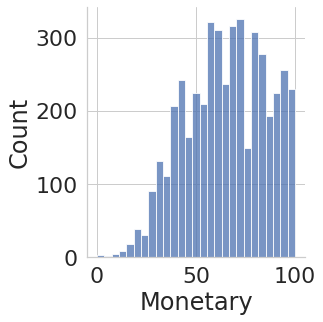

In [21]:
sns.displot(rfm.Monetary)
# По полученному распределению можно сделать вывод, что сложно найти закономерность или четкие границы в получаемых учениками
# оценках. Поэтому в данном случае можно обратиться к рассуждениям о том, что во время обучения, оценки выражают не только
# быллами, но и названиями ('неудовлетворительно', 'удовлетворительно', 'хорошо', 'отлично'). Таким образом, студентов можно 
# поделить на тех, кто получает:
# 1 - 'неудовлетворительные' оценки (до 40 баллов)
# 2 - 'удовлетворительные' оценки (от 40 до 60 баллов)
# 3 - 'хорошие' оценки (от 60 до 80 баллов)
# 4 - 'отличные' оценки (от 80 быллов)

In [41]:
def conv_r(x):
    if x <= 232.0:
        return 1
    elif 232.0 <= x <= 239.0:
        return 2
    elif x > 239.0:
        return 3

def conv_f(x):
    if x == 1.0:
        return 1
    elif x == 0.5:
        return 2
    elif x == 0.0:
        return 3

def conv_m(x):
    if x < 40:
        return 1
    elif 40 <= x < 60:
        return 2
    elif 60 <= x < 80:
        return 3
    elif x >= 80:
        return 4

rfm = rfm.fillna(0)
rfm.Recency = rfm.Recency.apply(lambda x: conv_r(x)).astype('str')
rfm.Frequency = rfm.Frequency.apply(lambda x: conv_f(x)).astype('int').astype('str')
rfm.Monetary = rfm.Monetary.apply(lambda x: conv_m(x)).astype('str')
rfm

,id_student,Recency,Frequency,Monetary
0,23698,3,1,4
1,24213,2,1,2
2,27116,3,1,4
3,28046,2,3,2
4,28787,3,1,2
...,...,...,...,...
4628,2694886,2,1,3
4629,2694933,1,1,3
4630,2695608,2,1,3
4631,2697181,1,1,4


In [42]:
rfm.dtypes

id_student     int64
Recency       object
Frequency     object
Monetary      object
dtype: object

In [45]:
print('ОТВЕТ / ANSWER:')
rfm = rfm.assign(RFM = rfm.Recency + rfm.Frequency + rfm.Monetary)
rfm[['id_student', 'RFM']]

ОТВЕТ / ANSWER:


,id_student,RFM
0,23698,314
1,24213,212
2,27116,314
3,28046,232
4,28787,312
...,...,...
4628,2694886,213
4629,2694933,113
4630,2695608,213
4631,2697181,114
